In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import RandomizedSearchCV
import joblib
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [3]:
df_train = pd.read_csv('C:/Users/Nat Andrew/Desktop/CustomerChurnPrediction/data/churn_train.csv')
df_test = pd.read_csv('C:/Users/Nat Andrew/Desktop/CustomerChurnPrediction/data/churn_test.csv')

In [5]:
#Data preprocessing
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

df_train = pd.get_dummies(df_train, drop_first=True)
df_test = pd.get_dummies(df_test, drop_first=True)

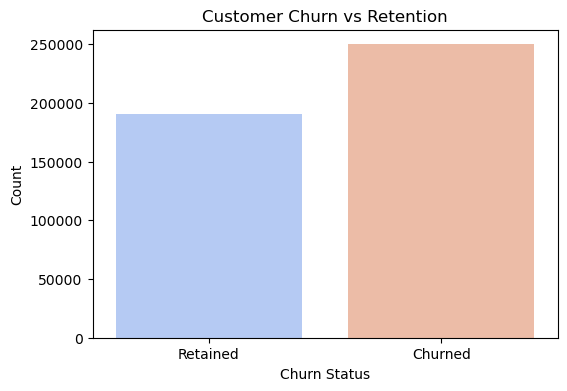

Churn                         1.000000
Support Calls                 0.574267
Contract Length_Monthly       0.433553
Total Spend                   0.429355
Payment Delay                 0.312129
Age                           0.218394
Contract Length_Quarterly     0.176244
Gender_Male                   0.175395
Last Interaction              0.149616
Tenure                        0.051919
Usage Frequency               0.046101
Subscription Type_Premium     0.011072
Subscription Type_Standard    0.009247
Name: Churn, dtype: float64


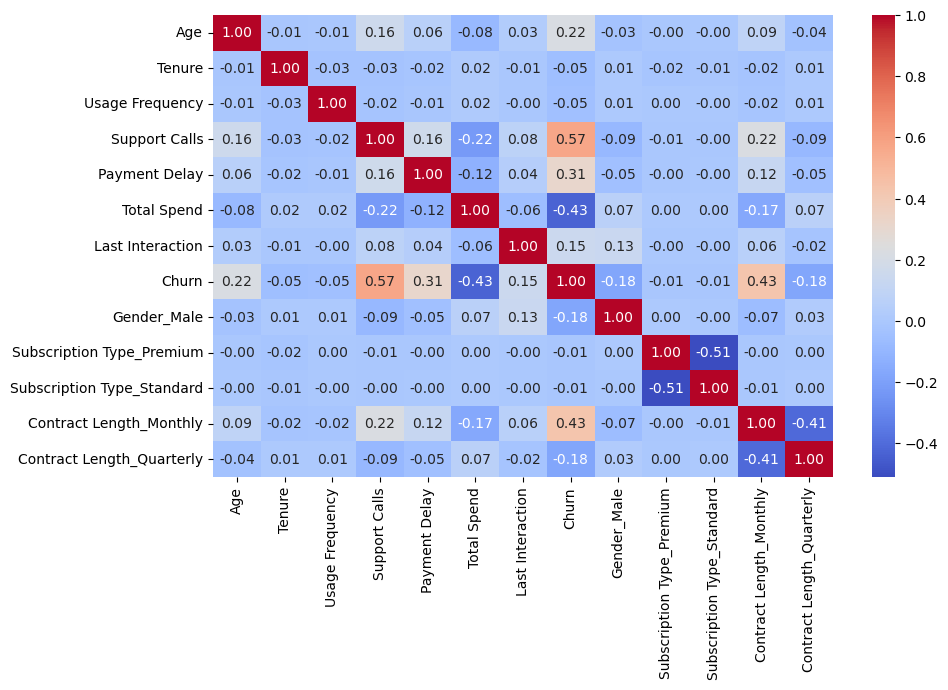

In [7]:
#EDA
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df_train, hue='Churn', palette='coolwarm', legend=False)
plt.title('Customer Churn vs Retention')
plt.xlabel('Churn Status')
plt.ylabel('Count')
plt.xticks([0,1], ['Retained', 'Churned'])
plt.show()

cor_m = df_train.loc[:, df_train.columns != 'CustomerID'].corr()
churn_corr = cor_m['Churn'].abs().sort_values(ascending=False)
print(churn_corr)

plt.figure(figsize=(10, 6))
sns.heatmap(cor_m, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

Classification report for logistic regression: 

              precision    recall  f1-score   support

           0       0.96      0.19      0.32     33881
           1       0.53      0.99      0.69     30493

    accuracy                           0.57     64374
   macro avg       0.74      0.59      0.50     64374
weighted avg       0.75      0.57      0.49     64374

ROC-AUC: 0.7602421274311939 



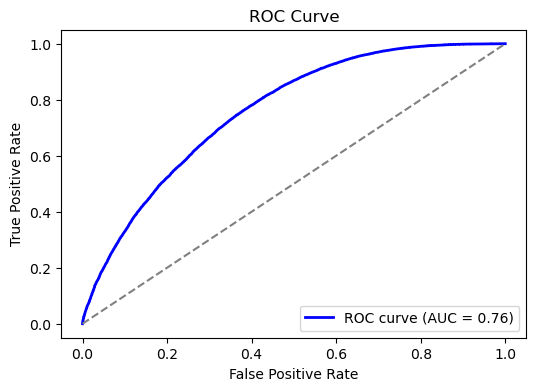

['C:/Users/Nat Andrew/Desktop/CustomerChurnPrediction/models/lda.pkl']

In [9]:
# Model building
X_train = df_train.drop(columns=['CustomerID', 'Churn'])
# mock_df = df_train.drop(columns=['CustomerID', 'Churn'])
X_test = df_test.drop(columns=['CustomerID', 'Churn'])
y_train = df_train['Churn']
y_test = df_test['Churn']

##Resampling didn't improve score since the data wasn't really imbalanced
# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

# tomek = TomekLinks()
# X_train, y_train = tomek.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Dimensionality reduction technique(LDA)
lda = LinearDiscriminantAnalysis(n_components=1)
X_train = lda.fit_transform(X_train, y_train)
X_test = lda.transform(X_test)

#Logistic Regression
lr = LogisticRegression(solver='liblinear', penalty='l1', max_iter=100, C=0.01, random_state=42)
lr.fit(X_train, y_train)

# #Feature importance
# feature_importance = pd.DataFrame({'Feature': mock_df.columns, 'Importance': abs(lr.coef_[0])})
# feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
# print(feature_importance)

y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, th = roc_curve(y_test, y_pred_proba)

#ROC-AUC 0.76 -> 0.76 after hyperparameter tuning
print('Classification report for logistic regression:', '\n')
print(classification_report(y_test, y_pred))
print('ROC-AUC:', roc_auc, '\n')

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

#Deployment purpose
joblib.dump(lr, 'C:/Users/Nat Andrew/Desktop/CustomerChurnPrediction/models/churn_model.pkl')
joblib.dump(scaler, 'C:/Users/Nat Andrew/Desktop/CustomerChurnPrediction/models/scaler.pkl')
joblib.dump(lda, 'C:/Users/Nat Andrew/Desktop/CustomerChurnPrediction/models/lda.pkl')

Classification report for random forest: 

              precision    recall  f1-score   support

           0       0.96      0.21      0.35     33881
           1       0.53      0.99      0.69     30493

    accuracy                           0.58     64374
   macro avg       0.74      0.60      0.52     64374
weighted avg       0.75      0.58      0.51     64374

ROC-AUC: 0.7191164138927265 



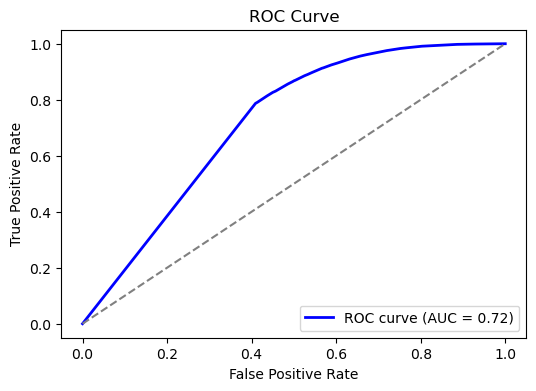

In [11]:
#Random Forest
X_train = df_train.drop(columns=['CustomerID', 'Churn'])
X_test = df_test.drop(columns=['CustomerID', 'Churn'])

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lda = LinearDiscriminantAnalysis(n_components=1)
X_train = lda.fit_transform(X_train, y_train)
X_test = lda.transform(X_test)

rf = RandomForestClassifier(n_estimators=300, min_samples_split=10, min_samples_leaf=4, max_features='log2', max_depth=10, bootstrap=False, random_state=42)
rf.fit(X_train, y_train)

# #Feature importance
# features_df = pd.DataFrame({
#     'Features': X_train.columns,
#     'Importance': rf.feature_importances_
# })
# features_df = features_df.sort_values(by='Importance', ascending=False)
# print(features_df)

y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, th = roc_curve(y_test, y_pred_proba)

#ROC-AUC 0.66 -> 0.72 after hyperparameter tuning
print('Classification report for random forest:', '\n')
print(classification_report(y_test, y_pred))
print('ROC-AUC:', roc_auc, '\n')

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Classification report for XGBoost: 

              precision    recall  f1-score   support

           0       0.97      0.15      0.26     33881
           1       0.51      1.00      0.68     30493

    accuracy                           0.55     64374
   macro avg       0.74      0.57      0.47     64374
weighted avg       0.75      0.55      0.46     64374

ROC-AUC: 0.7308239560014272 



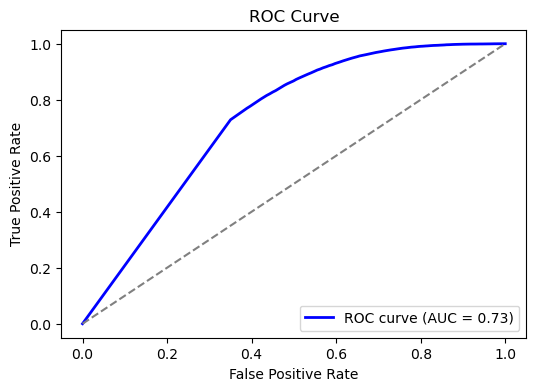

In [13]:
#XGBoost
X_train = df_train.drop(columns=['CustomerID', 'Churn', 'Contract Length_Quarterly', 'Subscription Type_Standard'])
X_test = df_test.drop(columns=['CustomerID', 'Churn', 'Contract Length_Quarterly', 'Subscription Type_Standard'])

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lda = LinearDiscriminantAnalysis(n_components=1)
X_train = lda.fit_transform(X_train, y_train)
X_test = lda.transform(X_test)

xgb = XGBClassifier(subsample=0.875, scale_pos_weight=2, reg_lambda=1.0, reg_alpha=0.1, n_estimators=700, min_child_weight=9, max_depth=4, learning_rate=0.20333333333333334, gamma=5.0, colsample_bytree=0.625, random_state=42)
xgb.fit(X_train, y_train) 

# #Feature importance
# plot_importance(xgb, importance_type='gain')
# plt.show()

y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, th = roc_curve(y_test, y_pred_proba)

#ROC-AUC 0.73 -> 0.73 after hyperparameter tuning
print('Classification report for XGBoost:', '\n')
print(classification_report(y_test, y_pred))
print('ROC-AUC:', roc_auc, '\n')

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# #Logistic Regression Hyperparameter Tuning
# param_dist = {
#     'penalty': ['l1', 'l2', 'elasticnet', None],
#     'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
#     'solver': ['liblinear', 'saga'],
#     'max_iter': [100, 200, 500, 1000]
# }
# random_search = RandomizedSearchCV(
#     estimator=lr,
#     param_distributions=param_dist,
#     n_iter=10,
#     scoring='roc_auc',
#     cv=5,
#     verbose=1,
#     n_jobs=-1
# )

# random_search.fit(X_train, y_train)

# print("Best Parameters:", random_search.best_params_)
# print("Best ROC-AUC Score:", random_search.best_score_)

In [ ]:
# #Random Forest Hyperparameter Tuning
# param_dist = {
#     'n_estimators': [100, 200, 300, 500],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth': [None, 10, 20, 30, 40],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False]
# }
# random_search = RandomizedSearchCV(
#     estimator=rf,
#     param_distributions=param_dist,
#     n_iter=10,
#     scoring='roc_auc',
#     cv=5,
#     verbose=1,
#     n_jobs=-1
# )

# random_search.fit(X_train, y_train)

# print("Best Parameters:", random_search.best_params_)
# print("Best ROC-AUC Score:", random_search.best_score_)

In [ ]:
# #XGBoost Hyperparameter Tuning
# param_dist = {
#     'n_estimators': np.arange(100, 1000, 100),
#     'max_depth': np.arange(3, 12),
#     'learning_rate': np.linspace(0.01, 0.3, 10),
#     'subsample': np.linspace(0.5, 1.0, 5),
#     'colsample_bytree': np.linspace(0.5, 1.0, 5),
#     'gamma': np.linspace(0, 5, 6),
#     'reg_alpha': np.logspace(-3, 1, 5),
#     'reg_lambda': np.logspace(-3, 1, 5),
#     'min_child_weight': np.arange(1, 10),
#     'scale_pos_weight': [1, 2, 5, 10, 20]
# }
# random_search = RandomizedSearchCV(
#     estimator=xgb,
#     param_distributions=param_dist,
#     n_iter=20,
#     scoring='roc_auc',
#     cv=5,
#     verbose=1,
#     n_jobs=-1
# )

# random_search.fit(X_train, y_train)

# print('Best Param:', random_search.best_params_)
# print('Best ROC-AUC:', random_search.best_score_)